In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
#Read csv files and clean

AC_Power = pd.read_csv("../data/Data_9068/9068_ac_power_data_2022.csv")
AC_Power["measured_on"] = pd.to_datetime(AC_Power["measured_on"])
AC_Power = AC_Power[AC_Power["measured_on"].dt.month.isin([1,10,11,12])]
AC_Power["Power"] = AC_Power[["inverter_1_ac_power_(kw)_inv_150143","inverter_2_ac_power_(kw)_inv_150144"]].sum(axis=1)
AC_Power.dropna(inplace=True)
Power = AC_Power.drop(columns=AC_Power.columns[1:-1])

In [137]:
Temperature = pd.read_csv("../data/Data_9068/9068_environment_data_2022.csv")

Temperature["measured_on"] = pd.to_datetime(Temperature["measured_on"])
Temperature = Temperature[Temperature["measured_on"].dt.month.isin([1,10,11,12])]

In [138]:
Weather = pd.read_csv("../data/NREL_Weather/1000190_40.38_-104.55_2022.csv",header=2)
Weather_features = ["Temperature", "Relative Humidity", "Wind Speed", "Cloud Type"]
Weather["DateTime"] = pd.to_datetime(Weather[["Year","Month","Day","Hour","Minute"]])
Weather = Weather.drop(columns=["Year","Month","Day","Hour","Minute"])
Weather = Weather[Weather["DateTime"].dt.month.isin([1,10,11,12])]
Weather_Reduced = Weather[Weather_features+["DateTime"]].copy()

In [139]:
AC_Power.iloc[32891,:][["measured_on","Power"]]

measured_on    2022-12-25 10:10:00
Power                        642.0
Name: 103226, dtype: object

In [140]:
Weather.iloc[33530,:][["GHI","DateTime"]]

GHI                           0
DateTime    2022-12-25 10:10:00
Name: 103226, dtype: object

In [141]:
Weather.iloc[33614,:][["GHI","DateTime"]]

GHI                           9
DateTime    2022-12-25 17:10:00
Name: 103310, dtype: object

In [142]:
Weather.iloc[33446,:][["GHI","DateTime"]]

GHI                           0
DateTime    2022-12-25 03:10:00
Name: 103142, dtype: object

In [143]:
Merged_data = pd.merge(Power,Temperature,left_on="measured_on",right_on="measured_on",how="inner")
Merged_data = pd.merge(Merged_data,Weather_Reduced,left_on="measured_on",right_on="DateTime",how="inner")
Merged_data.drop(columns=["measured_on"],inplace=True)
Merged_data.rename(columns={Merged_data.columns[1]: "Ambient Temperature",Merged_data.columns[2]: "Wind Sensor"}, inplace=True)

In [144]:
Merged_data = Merged_data[Merged_data["Power"]>0]

In [145]:
#Dataframe of for each day

aggregation = {col: "mean" for col in Merged_data.columns[:-1]}
aggregation.update({"Power": "sum", "Cloud Type":lambda x: x.mode().iloc[0] if not x.mode().empty else None})

Merged_Daily = Merged_data.resample("d", on="DateTime").agg(aggregation)
Merged_Daily.dropna(inplace = True)

In [ ]:
Merged_Daily_Int = Merged_Daily.copy().drop(columns=["Temperature","Wind Speed"])
Merged_Daily_Int["Ambient Temperature"] += 273
Merged_Daily_Int["TT"] = Merged_Daily_Int["Ambient Temperature"]**2
Merged_Daily_Int["TH"] = Merged_Daily_Int["Ambient Temperature"]*Merged_Daily_Int["Relative Humidity"]
Merged_Daily_Int["HH"] = Merged_Daily_Int["Relative Humidity"]**2

In [147]:
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

def linear_models(df,target:str,features:list,splits = 5):
    cv=KFold(n_splits=splits, shuffle=True)
    results = []
    y = df[target]

    for i in range(1,len(features)+1):
        for subset in itertools.combinations(features, i):
            X = df[list(subset)]
            mlr = LinearRegression()
            rmse_scores = cross_val_score(mlr, X, y, cv=cv,scoring="neg_root_mean_squared_error")
            r2_scores = cross_val_score(mlr, X, y, cv=cv,scoring="r2")
            adj_r2_scores = []
            n_samples, n_features = X.shape
            for score in r2_scores:
                adj_r2 = 1-(1-score)*(n_samples-n_features)/(n_samples-n_features-1)
                adj_r2_scores.append(adj_r2)
            mlr.fit(X,y)

            results.append({
                'features': subset,
                'cv_rmse_mean_score': np.mean(rmse_scores),
                'cv_rmse_std': np.std(rmse_scores),
                'cv_r2_mean_score': np.mean(r2_scores),
                'cv_r2_std': np.std(r2_scores),
                'cv_adjr2_mean_score' : np.mean(adj_r2_scores),
                'cv_adj_std' : np.std(adj_r2_scores),
                'coeff' : mlr.coef_,
                'intercept' : mlr.intercept_
            })
    return results

In [166]:
Models = linear_models(Merged_Daily_Int,"Power",Merged_Daily_Int.columns[1:],5)

In [167]:
sorted_Models1 = sorted(Models, key=lambda k:k["cv_adjr2_mean_score"],reverse=True)
print("Best models based on adjr2:")
for i in range(3):
    print(sorted_Models1[i]["features"],sorted_Models1[i]["cv_adjr2_mean_score"])

sorted_Models2 = sorted(Models, key=lambda k:k["cv_rmse_mean_score"],reverse=True)
print("Best models based on cv_rmse_mean_score:")
for i in range(3):
    print(sorted_Models2[i]["features"],sorted_Models2[i]["cv_rmse_mean_score"])

sorted_Models3 = sorted(Models, key=lambda k:k["cv_r2_mean_score"],reverse=True)
print("Best models based on cv_r2_mean_score:")
for i in range(3):
    print(sorted_Models3[i]["features"],sorted_Models3[i]["cv_r2_mean_score"])

Best models based on adjr2:
('Ambient Temperature', 'Wind Sensor', 'Relative Humidity', 'Cloud Type', 'TT', 'TH') 0.5658392546960067
('Relative Humidity', 'Cloud Type', 'TH') 0.5657238795664059
('Ambient Temperature', 'Cloud Type', 'TT', 'TH') 0.5441572914206622
Best models based on cv_rmse_mean_score:
('Wind Sensor', 'Relative Humidity', 'Cloud Type', 'TH', 'HH') -53016.863509365205
('Ambient Temperature', 'Relative Humidity', 'Cloud Type', 'TT', 'TH', 'HH') -53192.53140472826
('Relative Humidity', 'Cloud Type', 'TT', 'TH', 'HH') -53608.72638596606
Best models based on cv_r2_mean_score:
('Ambient Temperature', 'Wind Sensor', 'Relative Humidity', 'Cloud Type', 'TT', 'TH') 0.5695820197417308
('Relative Humidity', 'Cloud Type', 'TH') 0.5693732587297134
('Ambient Temperature', 'Cloud Type', 'TT', 'TH') 0.5480203652221819


In [150]:
mean_regressor = DummyRegressor(strategy="mean")
mean_regressor.fit(Merged_Daily_Int["TT"], Merged_Daily_Int["Power"])
baseline_pred = mean_regressor.predict(Merged_Daily_Int["Power"])

sc = cross_val_score(mean_regressor,Merged_Daily_Int["TT"],Merged_Daily_Int["Power"],cv=5,scoring="r2")
print(sc.mean())

-0.9143809948697822


In [151]:
#Read csv files and clean

AC_Power2 = pd.read_csv("../data/Data_9068/9068_ac_power_data_20240101_20250430.csv")
AC_Power2["measured_on"] = pd.to_datetime(AC_Power2["measured_on"])
AC_Power2 = AC_Power2[(AC_Power2["measured_on"].dt.year ==  2024)&(AC_Power2["measured_on"].dt.month.isin([1,10,11,12]))]
AC_Power2["Power"] = AC_Power2[["inverter_1_ac_power_(kw)_inv_150143","inverter_2_ac_power_(kw)_inv_150144"]].sum(axis=1)
AC_Power2.dropna(inplace=True)
Power2 = AC_Power2.drop(columns=AC_Power2.columns[1:-1])

In [152]:
Temperature2 = pd.read_csv("../data/Data_9068/9068_environment_data_20240101_20250430.csv")

Temperature2_Reduced = Temperature2[[list(Temperature2.columns)[i] for i in [0,1,9]]].copy()
Temperature2_Reduced["measured_on"] = pd.to_datetime(Temperature2_Reduced["measured_on"])
Temperature2_Reduced = Temperature2_Reduced[(Temperature2_Reduced["measured_on"].dt.year ==  2024)&(Temperature2_Reduced["measured_on"].dt.month.isin([1,10,11,12]))]

In [153]:
Weather2 = pd.read_csv("../data/NREL_Weather/1000190_40.38_-104.55_2024.csv",header=2)
Weather2_features = ["Relative Humidity", "Cloud Type"]
Weather2["DateTime"] = pd.to_datetime(Weather2[["Year","Month","Day","Hour","Minute"]])
Weather2 = Weather2.drop(columns=["Year","Month","Day","Hour","Minute"])
Weather2 = Weather2[Weather2["DateTime"].dt.month.isin([1,10,11,12])]
Weather2_Reduced = Weather2[Weather2_features+["DateTime"]].copy()

In [154]:
Merged_data2 = pd.merge(Power2,Temperature2_Reduced,left_on="measured_on",right_on="measured_on",how="inner")
Merged_data2 = pd.merge(Merged_data2,Weather2_Reduced,left_on="measured_on",right_on="DateTime",how="inner")
Merged_data2.drop(columns=["measured_on"],inplace=True)
Merged_data2.rename(columns={Merged_data2.columns[1]: "Ambient Temperature",Merged_data2.columns[2]: "Wind Sensor"}, inplace=True)

In [155]:
aggregation = {col: "mean" for col in Merged_data2.columns[:-1]}
aggregation.update({"Power": "sum", "Cloud Type":lambda x: x.mode().iloc[0] if not x.mode().empty else None})

Merged_Daily2 = Merged_data2.resample("d", on="DateTime").agg(aggregation)
Merged_Daily2.dropna(inplace = True)

In [156]:
Merged_Daily2_Int = Merged_Daily2.copy()
Merged_Daily2_Int["Ambient Temperature"] += 273
Merged_Daily2_Int["TT"] = Merged_Daily2_Int["Ambient Temperature"]**2
Merged_Daily2_Int["TH"] = Merged_Daily2_Int["Ambient Temperature"]*Merged_Daily2_Int["Relative Humidity"]
Merged_Daily2_Int["HH"] = Merged_Daily2_Int["Relative Humidity"]**2

In [157]:
i=0
for model in Models:
    y24rms = np.inf
    y24r2 = -np.inf
    best_y24mrmse = []
    best_y24r2 = []
    feat = list(model["features"])
    coefficients = list(model["coeff"])
    intercept = model["intercept"]
    test24 = Merged_Daily2_Int[feat].copy()
    test24["Prediction"] = sum(test24[col]*coef for col,coef in zip(feat,coefficients))+intercept
    test24["Power"] = Merged_Daily2_Int["Power"]
    test24["Residual"] = test24["Prediction"]-test24["Power"]
    sq_res = (((test24["Power"]-test24["Prediction"])**2).sum(axis=0))
    tot_sq = (((test24["Power"]-test24["Power"].mean())**2).sum(axis=0))
    if np.sqrt(np.mean(test24["Residual"]**2)) < y24rms:
        y24rms = np.sqrt(np.mean(test24["Residual"]**2))
        best_y24mrmse = model
        j = i
    if 1-sq_res/tot_sq > y24r2:
        y24r2 = 1-sq_res/tot_sq
        best_y24r2 = model
        k = i
    i+=1

In [158]:
print(best_y24mrmse['features'],y24rms)
print(best_y24r2['features'],y24r2)

('Ambient Temperature', 'Wind Sensor', 'Relative Humidity', 'Cloud Type', 'TT', 'TH', 'HH') 62302.58733845475
('Ambient Temperature', 'Wind Sensor', 'Relative Humidity', 'Cloud Type', 'TT', 'TH', 'HH') 0.20217925689570104


In [159]:
mean_regressor = DummyRegressor(strategy="mean")
mean_regressor.fit(Merged_Daily2_Int["TT"], Merged_Daily2_Int["Power"])
baseline_pred = mean_regressor.predict(Merged_Daily2_Int["Power"])

sc = cross_val_score(mean_regressor,Merged_Daily2_Int["TT"],Merged_Daily2_Int["Power"],cv=5,scoring="neg_root_mean_squared_error")
print(sc.mean())

-71647.95528090691


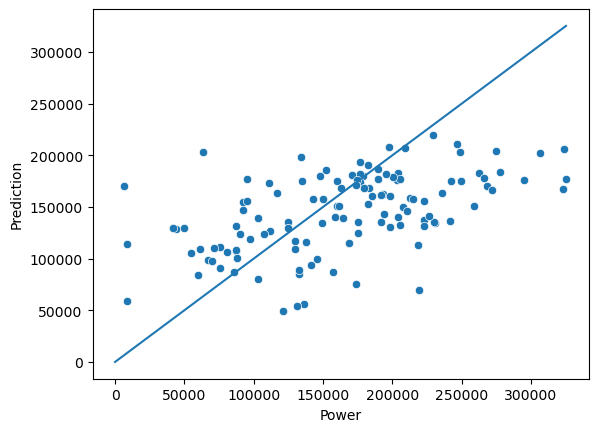

In [160]:
sns.scatterplot(test24, x="Power", y="Prediction")
X = np.linspace(0,test24["Power"].max(),2)
plt.plot(X,X)
plt.show()

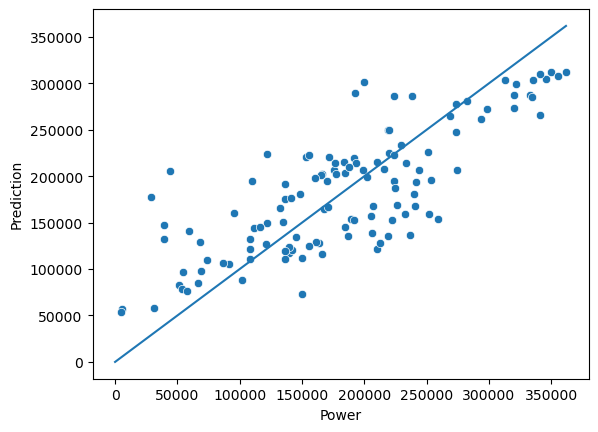

In [168]:
test22 = Merged_Daily_Int[feat]
test22["Prediction"] = sum(test22[col]*coef for col,coef in zip(feat,list(sorted_Models1[0]["coeff"])))+sorted_Models1[0]["intercept"]
test22["Power"] = Merged_Daily_Int["Power"]
test22["Residual"] = test22["Prediction"]-test22["Power"]

sns.scatterplot(test22, x="Power", y="Prediction")
X = np.linspace(0,test22["Power"].max(),2)
plt.plot(X,X)
plt.show()